In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [2]:
# ---- Reproducibility ----
np.random.seed(42)
tf.random.set_seed(42)


In [12]:
# ---- Generate data ----
X, y = make_moons(n_samples=20000, noise=0.25, random_state=42)


In [13]:
X

array([[-0.02288524,  0.01832383],
       [ 0.69928604,  0.55803652],
       [-1.24347622,  0.67783889],
       ...,
       [-0.27311534,  1.33773396],
       [ 0.71721135, -0.18806408],
       [ 1.45915043, -0.86026469]])

In [14]:
y

array([1, 0, 0, ..., 0, 0, 1])

In [15]:
# ---- Train/Val/Test split ----
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test,   y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)


In [16]:
X_train.shape, X_val.shape, X_test.shape

((14000, 2), (3000, 2), (3000, 2))

In [17]:
# ---- Scale features (fit on train only) ----
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

In [30]:
# ---- Build model (Functional API) ----
inputs = tf.keras.Input(shape=(2,), name="features")
x = tf.keras.layers.Dense(32, activation="relu", kernel_initializer="he_normal")(inputs)
x = tf.keras.layers.Dropout(0.15)(x)
x = tf.keras.layers.Dense(32, activation="relu", kernel_initializer="he_normal")(x)
x = tf.keras.layers.Dropout(0.15)(x)
x = tf.keras.layers.Dense(16, activation="relu", kernel_initializer="he_normal")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="prob")(x)


In [31]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                96        
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
prob (Dense)                 (None, 1)                 17  

In [32]:

# ---- Compile ----
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"), tf.keras.metrics.AUC(name="auc")]
)



In [33]:
# ---- Train ----
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
]

history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=400,
    batch_size=64,
    verbose=1,
    callbacks=callbacks,
)

Epoch 1/400
219/219 [==============================] - 1s 3ms/step - loss: 0.4341 - acc: 0.7948 - auc: 0.8862 - val_loss: 0.2569 - val_acc: 0.8757 - val_auc: 0.9627
Epoch 2/400
219/219 [==============================] - 0s 2ms/step - loss: 0.2805 - acc: 0.8694 - auc: 0.9533 - val_loss: 0.2236 - val_acc: 0.8983 - val_auc: 0.9719
Epoch 3/400
219/219 [==============================] - 0s 2ms/step - loss: 0.2473 - acc: 0.8920 - auc: 0.9635 - val_loss: 0.1908 - val_acc: 0.9220 - val_auc: 0.9792
Epoch 4/400
219/219 [==============================] - 0s 2ms/step - loss: 0.2195 - acc: 0.9125 - auc: 0.9708 - val_loss: 0.1627 - val_acc: 0.9377 - val_auc: 0.9852
Epoch 5/400
219/219 [==============================] - 0s 2ms/step - loss: 0.1968 - acc: 0.9227 - auc: 0.9766 - val_loss: 0.1493 - val_acc: 0.9463 - val_auc: 0.9872
Epoch 6/400
219/219 [==============================] - 0s 2ms/step - loss: 0.1863 - acc: 0.9280 - auc: 0.9786 - val_loss: 0.1425 - val_acc: 0.9490 - val_auc: 0.9880
Epoch 7/40


Test performance:
loss=0.1400  acc=0.9457  auc=0.9880


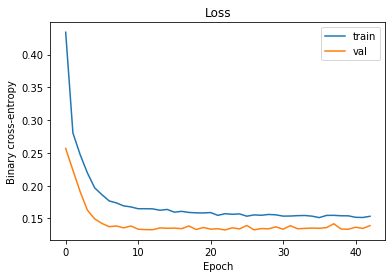

In [34]:
# ---- Evaluate ----
print("\nTest performance:")
test_loss, test_acc, test_auc = model.evaluate(X_test_s, y_test, verbose=0)
print(f"loss={test_loss:.4f}  acc={test_acc:.4f}  auc={test_auc:.4f}")

# ---- Optional: plot training curves ----
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy")
plt.legend()
plt.show()

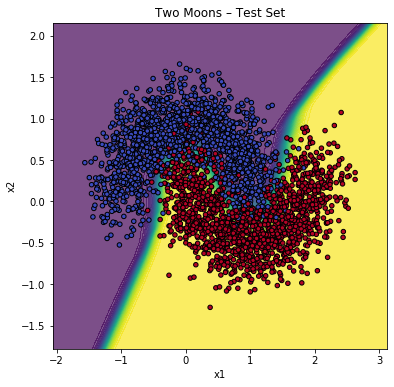

In [41]:
# ---- Optional: decision boundary ----
def plot_decision_boundary(model, scaler, X, y, title="Decision Boundary"):
    # Create a mesh over feature space
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 400),
        np.linspace(y_min, y_max, 400)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_s = scaler.transform(grid)
    zz = model.predict(grid_s, verbose=0).reshape(xx.shape)

    plt.figure(figsize=(6,6))
    plt.contourf(xx, yy, zz, levels=50, alpha=0.7)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolor="k", s=20, cmap="coolwarm")
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

plot_decision_boundary(model, scaler, X_test, y_test, title="Two Moons – Test Set")

In [42]:
# https://chatgpt.com/c/68cf7532-b424-832c-9142-c1e190aecb30

In [43]:
import os
import itertools
import tensorflow as tf
from tensorflow.keras import layers, models
from datasets import load_dataset

# ========== Config (override via env) ==========
tf.keras.utils.set_random_seed(42)
DATASET_ID  = os.getenv("HF_DATASET", "wikimedia/wikipedia")
CONFIG      = os.getenv("HF_CONFIG",  "20231101.en")   # snapshot/lang
DOC_LIMIT   = int(os.getenv("DOC_LIMIT",   "20000"))   # max number of articles to read
VOCAB_SIZE  = int(os.getenv("VOCAB_SIZE",  "20000"))
WINDOW      = int(os.getenv("WINDOW",      "5"))
BATCH_SIZE  = int(os.getenv("BATCH_SIZE",  "256"))
EPOCHS      = int(os.getenv("EPOCHS",      "3"))
PREFETCH    = tf.data.AUTOTUNE

# ========== Load HF streaming dataset ==========
# Split is "train" for dumps; streaming avoids full download.
print(f"[INFO] Loading HF dataset {DATASET_ID} / {CONFIG} (streaming=True)")
ds = load_dataset(DATASET_ID, CONFIG, split="train", streaming=True)

def stream_articles(dataset, doc_limit):
    """Yield raw article bodies as strings (skip empty/None)."""
    n = 0
    for ex in dataset:
        try:
            body = ex["text"]["body"]
        except Exception:
            # Some configs store plain string in 'text'
            body = ex.get("text", None)
        if body and isinstance(body, str) and body.strip():
            yield body
            n += 1
            if n >= doc_limit:
                break

# Wrap into a tf.data.Dataset of strings without materializing everything
tf_text_ds = tf.data.Dataset.from_generator(
    lambda: stream_articles(ds, DOC_LIMIT),
    output_signature=tf.TensorSpec(shape=(), dtype=tf.string)
).prefetch(PREFETCH)

# ========== Vectorizer ==========
vectorizer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
)
print("[INFO] Adapting vocabulary…")
vectorizer.adapt(tf_text_ds.batch(256))

vocab = vectorizer.get_vocabulary()
V = min(VOCAB_SIZE, len(vocab))
print(f"[INFO] Final vocab size: {V}")

# ========== Build (X, y) windows ==========
@tf.function
def text_to_windows(text):
    ids = vectorizer(text)                     # [L]
    nz = tf.where(ids > 0)[:, 0]
    ids = tf.gather(ids, nz)
    L = tf.shape(ids)[0]
    K = WINDOW + 1

    def make_frames():
        frames = tf.signal.frame(ids, frame_length=K, frame_step=1, pad_end=False)  # [N, K]
        X_ids  = frames[:, :WINDOW]                               # [N, WINDOW]
        y_id   = frames[:, -1]                                    # [N]
        X_oh   = tf.one_hot(X_ids, depth=V, dtype=tf.float32)     # [N, WINDOW, V]
        X      = tf.reshape(X_oh, [-1, WINDOW * V])               # [N, WINDOW*V]
        y      = tf.one_hot(y_id, depth=V, dtype=tf.float32)      # [N, V]
        return X, y

    return tf.cond(
        L >= K,
        true_fn=make_frames,
        false_fn=lambda: (tf.zeros([0, WINDOW*V], tf.float32),
                          tf.zeros([0, V], tf.float32))
    )

def build_xy_dataset(text_ds):
    # Map each article → (X_batch, y_batch) then flatten
    ds_xy = text_ds.map(text_to_windows, num_parallel_calls=PREFETCH)
    ds_xy = ds_xy.flat_map(lambda X, y: tf.data.Dataset.from_tensor_slices((X, y)))
    return ds_xy

xy_ds = build_xy_dataset(tf_text_ds).shuffle(4096).batch(BATCH_SIZE).prefetch(PREFETCH)

# ========== Dense-only model ==========
inputs  = layers.Input(shape=(WINDOW * V,), name="onehot_context")
x = layers.Dense(1024, activation="relu")(inputs); x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation="relu")(x);      x = layers.Dropout(0.2)(x)
outputs = layers.Dense(V, activation="softmax")(x)
model   = models.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

model.fit(xy_ds, epochs=EPOCHS)

# ========== Inference helpers ==========
def encode_context(context_text):
    ids = vectorizer(tf.convert_to_tensor([context_text]))[0]
    nz = tf.where(ids > 0)[:, 0]
    ids = tf.gather(ids, nz)
    ids = ids[-WINDOW:]
    pad = WINDOW - tf.shape(ids)[0]
    ids = tf.concat([tf.zeros([pad], dtype=ids.dtype), ids], axis=0)
    X_oh = tf.one_hot(ids, depth=V, dtype=tf.float32)
    return tf.reshape(X_oh, [1, WINDOW * V])

def predict_next_token(context_text, top_k=5):
    X = encode_context(context_text)
    probs = model.predict(X, verbose=0)[0]
    top = tf.math.top_k(probs, k=top_k)
    toks = [vocab[i] for i in top.indices.numpy().tolist()]
    return list(zip(toks, [float(probs[i]) for i in top.indices.numpy().tolist()]))

ctx = "deep learning models can"
print("\nContext:", ctx)
for tok, p in predict_next_token(ctx, top_k=5):
    print(f"{tok:>15s}  {p:.4f}")


ModuleNotFoundError: No module named 'datasets'

In [ ]:
# How will we use it?

overall_response = []
1. while True:
        next_word_probs = model.predict(sentence)
        nextword = dictionary[max_idx(next_word_probs)]
        overall_response.append(nextword)
        if next_word == 'EOS':
            break
        sentence = sentence[1:] + next_word
        

In [ ]:
model -> 20,000 probabilities


In [46]:
import random
# Create a biased coin, which print head 90%, Tail 10%
def coin_toss(prob_head): # return 1 for head, 0 for tail
    # prob_head == .9, return approx 9 out of 10 times 1.
    # random.random() which produces a random number between 0 and 1
    if random.random() < prob_head:
        return 1
    return 0

In [47]:
data = []
for i in range(10000):
    data.append(coin_toss(.9))


In [48]:
sum(data)/len(data)

0.8963

In [63]:
def weighted_chances(p0, p1, p2): 
    # [.1, .2, .7] -> 0 - 10%, 1 - 20%, 2 70%
    r = random.random()
    
    if r < p0:
        return 0
    if r < p0 + p1:
        return 1
    return 2

In [64]:
data = []
for _ in range(10000):
    r = weighted_chances(.1, .2, .7)
    data.append(r)


In [65]:
d = {}
for i in data:
    d[i] = d.get(i, 0) + 1
    

In [66]:
d

{2: 7050, 0: 975, 1: 1975}

In [67]:
def weighted_chances(probs):
    # .1, .1, .1, .4, .3
    # commulative
    for i, v in enumerate(probs[:-1]):
        probs[i+1] += probs[i]
    r = random.random()
    for i, p in enumerate(probs):
        if r < p:
            return i

In [69]:
data = []
for _ in range(10000):
    r = weighted_chances([.1, .2, .4, .3])
    data.append(r)
d = {}
for i in data:
    d[i] = d.get(i, 0) + 1
print(d)

{1: 2016, 2: 3946, 3: 3042, 0: 996}


In [ ]:
# temperature - low temperature - no randomness
# high temperate - more randomness

In [87]:
arr = np.array([.1, .1, .1, .7])
arr = (arr)**(3*3)
arr = arr/sum(arr)
arr

array([2.47809304e-08, 2.47809304e-08, 2.47809304e-08, 9.99999926e-01])

In [ ]:
next_word_probs = model.predict(words)
idx = weighted_chances(next_word_probs)
word = word_dict[idx]

In [ ]:
1. More layers
2. Instead of word by word -> byte pairing algorithm -> tiktoken
3. Context Length 5 -> 10,000
4. Instead of Dense layer -> Attention
5. LLM training == Whole internet
6. Q, EoQ, A, EoA, then retrained with Q/As from Quora, redit, stack overflow, in-house.
7. max_idx -> randomly pick words with weighted chances
[.9, .05, .05] -> pick first word with 90% chances,
[.5, .5, 0] -> 50% time first word, 50% second word.
multinomial distribution or weighted chances.
temperature


In [88]:
# Build a model which predicts next character using 1000 characters.
# Train it on wikipedia's data
# try with deep neural network with 30 layers

In [ ]:
set('# Build a model which predicts next character using 1000 characters.')